# Purpose

The purpose of this notebook is to clean and do some exploratory data analysis of the flight data that I obtained from the Bureau of Transportation Statistics website. I will use this data to categorize whether a flight will be delayed or not based on weather data obtained from DarkSky API. 

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='whitegrid', palette='pastel', font_scale=1.25)

## Data Cleaning

Before getting into any analysis, I will first do some cleaning of the data I obtained from both the Bureau of Transportation Statistics (BTS) and DarkSky API. First, I will import the data I gathered from the BTS. I will show my process using the data I gathered from February. As my process was the same for both January and February, I will only show one month.

In [2]:
df = pd.read_csv('2019_2.csv')
df.head()

,YEAR,MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN,ORIGIN_CITY_NAME,...,DEP_DELAY,DEP_DELAY_NEW,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ACTUAL_ELAPSED_TIME,FLIGHTS,DISTANCE,Unnamed: 24
0,2019,2,5,2019-02-01,AA,N110AN,12478,1247805,JFK,"New York, NY",...,-1.0,0.0,1133,1058.0,-35.0,0.0,359.0,1.0,2475.0,NaN
1,2019,2,6,2019-02-02,AA,N116AN,12478,1247805,JFK,"New York, NY",...,49.0,49.0,1133,1156.0,23.0,23.0,367.0,1.0,2475.0,NaN
2,2019,2,7,2019-02-03,AA,N105NN,12478,1247805,JFK,"New York, NY",...,-4.0,0.0,1133,1108.0,-25.0,0.0,372.0,1.0,2475.0,NaN
3,2019,2,1,2019-02-04,AA,N108NN,12478,1247805,JFK,"New York, NY",...,-4.0,0.0,1133,1126.0,-7.0,0.0,390.0,1.0,2475.0,NaN
4,2019,2,2,2019-02-05,AA,N110AN,12478,1247805,JFK,"New York, NY",...,-5.0,0.0,1133,1112.0,-21.0,0.0,377.0,1.0,2475.0,NaN


I will format the column names to lower case as well delete unnecessary information. This includes any columns that I will not be using as well as rows with missing data.

In [3]:
# Strip spaces and lower case columns 
df.columns = [column.strip().lower() for column in df.columns]
df.columns

Index(['year', 'month', 'day_of_week', 'fl_date', 'op_unique_carrier',
       'tail_num', 'origin_airport_id', 'origin_airport_seq_id', 'origin',
       'origin_city_name', 'dest_airport_id', 'dest', 'dest_city_name',
       'crs_dep_time', 'dep_time', 'dep_delay', 'dep_delay_new',
       'crs_arr_time', 'arr_time', 'arr_delay', 'arr_delay_new',
       'actual_elapsed_time', 'flights', 'distance', 'unnamed: 24'],
      dtype='object')

In [4]:
# Drop unnecessary columns
df.drop(['origin_airport_id', 'dest_airport_id', 'unnamed: 24'], axis=1, inplace=True)

In [5]:
# Drop rows with missing data in columns that we will use for predicting
total_rows = len(df.index)

# Drop na's
df.dropna(subset=['op_unique_carrier','origin','dest','crs_dep_time','crs_arr_time','arr_delay','distance'],inplace=True)
data_kept = len(df.index)/total_rows
print('Data Retained:'+str(round(data_kept*100,2))+' %')

Data Retained:96.84 %


Next, I will get the planned departure and arrival hours and carrier description.

In [6]:
df['dep_hour'] = df['crs_dep_time'].apply(lambda x: int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))

#For ARR_HOUR, take the actual arrival time
df['arr_hour'] = df['arr_time'].apply(lambda x:int(str(x)[:2]) if x>999 else int(str(x)[:1] if x>99 else 0))
df['arr_hour'] = df['arr_hour'].apply(lambda x:0 if x==24 else x)

In [7]:
# Add carrier descriptions
carrier_key = pd.read_csv('L_UNIQUE_CARRIERS.csv')
df = pd.merge(df,carrier_key,how='left', left_on='op_unique_carrier', right_on='Code')

df.head()

,year,month,day_of_week,fl_date,op_unique_carrier,tail_num,origin_airport_seq_id,origin,origin_city_name,dest,...,arr_time,arr_delay,arr_delay_new,actual_elapsed_time,flights,distance,dep_hour,arr_hour,Code,Description
0,2019,2,5,2019-02-01,AA,N110AN,1247805,JFK,"New York, NY",LAX,...,1058.0,-35.0,0.0,359.0,1.0,2475.0,8,10,AA,American Airlines Inc.
1,2019,2,6,2019-02-02,AA,N116AN,1247805,JFK,"New York, NY",LAX,...,1156.0,23.0,23.0,367.0,1.0,2475.0,8,11,AA,American Airlines Inc.
2,2019,2,7,2019-02-03,AA,N105NN,1247805,JFK,"New York, NY",LAX,...,1108.0,-25.0,0.0,372.0,1.0,2475.0,8,11,AA,American Airlines Inc.
3,2019,2,1,2019-02-04,AA,N108NN,1247805,JFK,"New York, NY",LAX,...,1126.0,-7.0,0.0,390.0,1.0,2475.0,8,11,AA,American Airlines Inc.
4,2019,2,2,2019-02-05,AA,N110AN,1247805,JFK,"New York, NY",LAX,...,1112.0,-21.0,0.0,377.0,1.0,2475.0,8,11,AA,American Airlines Inc.


In [8]:
# Save cleaned data
df.to_csv('cleaned_airline_data_2_2019.csv',index=False)

## Combine Data 

Now that I have cleaned my febraury data, I will now combine it with the data I gathered from January that I had saved earlier.

In [8]:
df1 = pd.read_csv('cleaned_airline_data.csv')
df1.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,tail_num,op_carrier_fl_num,origin,origin_city_name,...,arr_delay_new,arr_del15,arr_delay_group,arr_time_blk,distance,distance_group,dep_hour,arr_hour,Code,Description
0,2019,1,19,6,2019-01-19,9E,N176PQ,5245,MSP,"Minneapolis, MN",...,0.0,0.0,-2.0,1800-1859,596.0,3,15,18,9E,Endeavor Air Inc.
1,2019,1,20,7,2019-01-20,9E,N309PQ,5245,MSP,"Minneapolis, MN",...,0.0,0.0,-2.0,1900-1959,596.0,3,15,18,9E,Endeavor Air Inc.
2,2019,1,21,1,2019-01-21,9E,N176PQ,5245,MSP,"Minneapolis, MN",...,0.0,0.0,-2.0,1900-1959,596.0,3,15,18,9E,Endeavor Air Inc.
3,2019,1,22,2,2019-01-22,9E,N135EV,5245,MSP,"Minneapolis, MN",...,0.0,0.0,-2.0,1900-1959,596.0,3,15,18,9E,Endeavor Air Inc.
4,2019,1,23,3,2019-01-23,9E,N294PQ,5245,MSP,"Minneapolis, MN",...,0.0,0.0,-1.0,1900-1959,596.0,3,15,18,9E,Endeavor Air Inc.


In [9]:
df1.columns

Index(['year', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_unique_carrier', 'tail_num', 'op_carrier_fl_num', 'origin',
       'origin_city_name', 'origin_state_abr', 'dest', 'dest_city_name',
       'dest_state_abr', 'crs_dep_time', 'dep_time', 'dep_delay',
       'dep_delay_new', 'dep_del15', 'dep_delay_group', 'dep_time_blk',
       'crs_arr_time', 'arr_time', 'arr_delay', 'arr_delay_new', 'arr_del15',
       'arr_delay_group', 'arr_time_blk', 'distance', 'distance_group',
       'dep_hour', 'arr_hour', 'Code', 'Description'],
      dtype='object')

To ensure that I have the same columns in both datasets, I will drop some of the January columns that I do not need. Then, I will concatenate the two months using the concat function. Finally, I will save the file just in case. 

In [10]:
df1.drop(['tail_num', 'op_carrier_fl_num','origin_state_abr','dest_state_abr','dep_del15'
         , 'dep_delay_group', 'dep_time_blk','arr_del15',
       'arr_delay_group', 'arr_time_blk', 'distance_group'],axis=1, inplace=True)

In [11]:
df.columns

Index(['year', 'month', 'day_of_week', 'fl_date', 'op_unique_carrier',
       'tail_num', 'origin_airport_seq_id', 'origin', 'origin_city_name',
       'dest', 'dest_city_name', 'crs_dep_time', 'dep_time', 'dep_delay',
       'dep_delay_new', 'crs_arr_time', 'arr_time', 'arr_delay',
       'arr_delay_new', 'actual_elapsed_time', 'flights', 'distance',
       'dep_hour', 'arr_hour', 'Code', 'Description'],
      dtype='object')

In [15]:
combined_df = pd.concat([df, df1], join='inner')

In [16]:
combined_df = df

In [17]:
# Save both months together 
df.to_csv('cleaned_airline_janfeb.csv', index=False)

## Exploratory Data Analysis

Now that I have cleaned the data, I will do some exploratory data analysis. 

First, I will take a look at the total number of flights in my dataset, the average number of flights per day, the percent of flights with delays greater than 15 min, which is what I  

In [12]:
# total number of flights 
len(df.index)

516314

In [13]:
# Average number of flights per day
len(df.index)/31

16655.290322580644

In [14]:
# Percent of flights with delays greater than 15 min
len(df[df['arr_delay']>15].index)/len(df.index)

0.22385989920862112

In [15]:
df = pd.read_csv('cleaned_airline_janfeb.csv')

In [16]:
df['dest'].value_counts()

ATL    27907
ORD    22642
DFW    20599
CLT    17114
DEN    16476
LAX    15902
PHX    13234
IAH    13207
LGA    12344
SFO    11634
LAS    11470
DTW    10789
MCO    10755
MSP    10664
DCA    10482
BOS    10246
EWR     9499
JFK     9381
SEA     8967
SLC     8323
PHL     8126
FLL     7853
MIA     7145
SAN     6583
BWI     6534
TPA     5901
BNA     5556
DAL     5292
MDW     5089
STL     4642
       ...  
PSM       44
INL       44
CNY       43
ART       43
BRD       43
IMT       43
LCK       43
LWB       42
VEL       42
LBL       41
ALO       41
OME       41
ESC       41
UIN       40
HTS       37
GUC       36
SPN       35
APN       33
CYS       27
ELM       27
COD       26
OTH       24
STC       18
OGS       15
SMX       14
OWB        8
PPG        8
OGD        8
HGR        8
ADK        7
Name: dest, Length: 346, dtype: int64

In [17]:
top20_dest = list(df['dest'].value_counts().head(20).index)
print(top20_dest)
top20_dest_df = df[df['dest'].isin(top20_dest)][['op_unique_carrier','origin','dest','arr_delay','arr_delay_new','Description']]
top20_dest_df.head()

['ATL', 'ORD', 'DFW', 'CLT', 'DEN', 'LAX', 'PHX', 'IAH', 'LGA', 'SFO', 'LAS', 'DTW', 'MCO', 'MSP', 'DCA', 'BOS', 'EWR', 'JFK', 'SEA', 'SLC']


,op_unique_carrier,origin,dest,arr_delay,arr_delay_new,Description
0,AA,JFK,LAX,-35.0,0.0,American Airlines Inc.
1,AA,JFK,LAX,23.0,23.0,American Airlines Inc.
2,AA,JFK,LAX,-25.0,0.0,American Airlines Inc.
3,AA,JFK,LAX,-7.0,0.0,American Airlines Inc.
4,AA,JFK,LAX,-21.0,0.0,American Airlines Inc.


In [18]:
delays = (pd.DataFrame(top20_dest_df
                       .groupby('dest', as_index=False)['arr_delay_new']
                       .mean())
          .sort_values(by='arr_delay_new', ascending=False))
delays


,dest,arr_delay_new
18,SFO,31.159704
15,ORD,28.047787
14,MSP,25.558233
7,EWR,21.626487
1,BOS,20.928655
17,SEA,19.420207
5,DFW,19.080441
10,LAS,19.021186
12,LGA,18.864064
6,DTW,16.958198


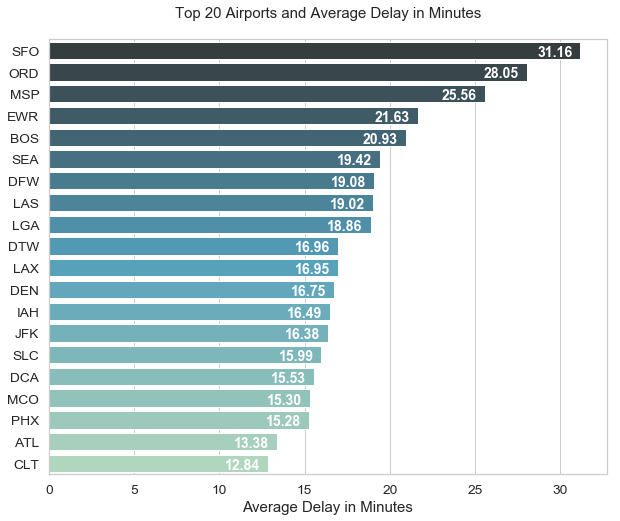

In [19]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='arr_delay_new',y='dest', data=delays, palette='GnBu_d')
ax.set_title('Top 20 Airports and Average Delay in Minutes\n')
ax.set_ylabel('')
ax.set_xlabel('Average Delay in Minutes')
fig = ax.get_figure()

for p in ax.patches:
    width = p.get_width()
    ax.text(width-1.5,
           p.get_y()+p.get_height()/2. + 0.25,
           '{:1.2f}'.format(width), ha='center', color='white', size='14', weight='bold')

### Arrival Delay Visualizations 

I will next visualize the arrival delays for the top 20 airlines. The top 20 airlines are defined as the airlines with the top 20 most flights in our dataset.

In [20]:
df['op_unique_carrier'].value_counts()

WN    94683
AA    70032
DL    67117
OO    56394
UA    43441
YX    22784
B6    21983
MQ    21813
OH    20366
AS    18039
9E    17633
YV    15909
NK    13436
EV    10880
F9     8633
G4     7157
HA     6014
Name: op_unique_carrier, dtype: int64

In [21]:
top20 = list(df['op_unique_carrier'].value_counts().head(20).index)
print(top20)
top20_df = df[df['op_unique_carrier'].isin(top20)][['op_unique_carrier','origin','dest','arr_delay','Description']]
top20_df.head()

['WN', 'AA', 'DL', 'OO', 'UA', 'YX', 'B6', 'MQ', 'OH', 'AS', '9E', 'YV', 'NK', 'EV', 'F9', 'G4', 'HA']


,op_unique_carrier,origin,dest,arr_delay,Description
0,AA,JFK,LAX,-35.0,American Airlines Inc.
1,AA,JFK,LAX,23.0,American Airlines Inc.
2,AA,JFK,LAX,-25.0,American Airlines Inc.
3,AA,JFK,LAX,-7.0,American Airlines Inc.
4,AA,JFK,LAX,-21.0,American Airlines Inc.


In [22]:
top20_df.to_csv('top20_airlines_janfeb.csv', index=False)
top20_df.head()

,op_unique_carrier,origin,dest,arr_delay,Description
0,AA,JFK,LAX,-35.0,American Airlines Inc.
1,AA,JFK,LAX,23.0,American Airlines Inc.
2,AA,JFK,LAX,-25.0,American Airlines Inc.
3,AA,JFK,LAX,-7.0,American Airlines Inc.
4,AA,JFK,LAX,-21.0,American Airlines Inc.


Out of the 20 airlines that have had the most flights, let's take a look at who has had delays greater than 30 minutes. 

In [24]:
temp_df = top20_df.copy()

# Get delays greater than 30 minutes
temp_df['arr_delay'] = temp_df['arr_delay'].apply(lambda x: 30 if x >=30 else x)
temp_df['arr_delay'] = temp_df['arr_delay'].apply(lambda x: -30 if x <= -30 else x)

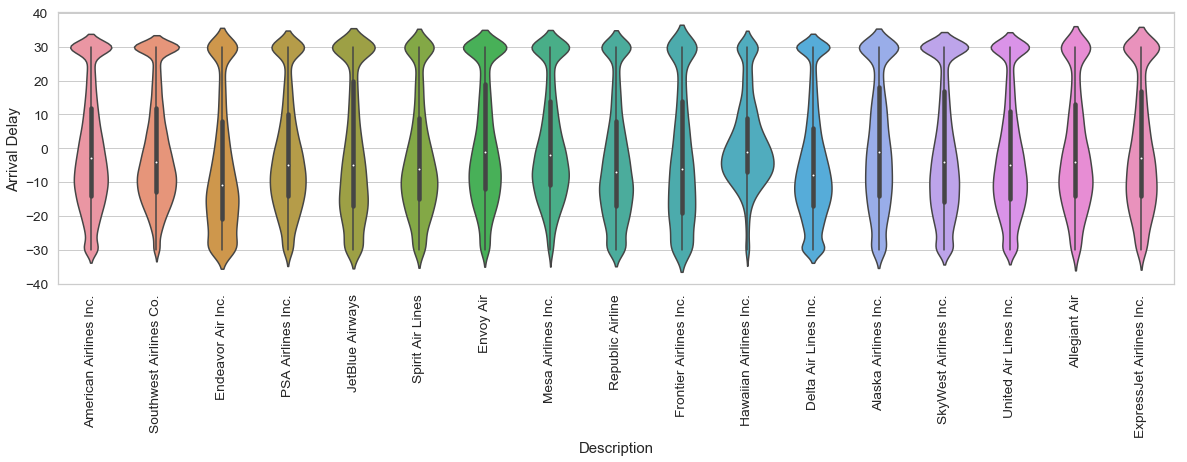

In [25]:
plt.figure(figsize=(20,5))
ax = sns.violinplot(x='Description', y='arr_delay', data=temp_df)
ax.set_ylabel('Arrival Delay')
label = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
fig = ax.get_figure()

As we can see from the above, the median for the top 20 airlines is around 0 to -10 minutes, meaning that most flights arrive before their scheduled time. The width of the plots at 30 represents the frequency of flights arriving 30 minutes or more after the scheduled arrival time.

Next, we will plot the percentage of all flights delayed more than 30 minutes.

In [26]:
delays = pd.DataFrame()

for uc in list(df['op_unique_carrier'].unique()):
    percent_delay = len(df[(df['op_unique_carrier']==uc) & (df['arr_delay']>=60)].index)/len(df[df['op_unique_carrier']==uc].index)*100
    delays = delays.append({'op_unique_carrier': uc, 'percent_delayed': percent_delay}, ignore_index=True)

delays = pd.merge(delays, carrier_key, how='left', left_on='op_unique_carrier', right_on='Code')
delays.drop(['op_unique_carrier', 'Code'], axis=1, inplace=True)
delays.rename(index=str, columns={'Description':'airline'}, inplace=True)
delays.sort_values(by=['percent_delayed'], ascending=False, inplace=True)
delays

,percent_delayed,airline
4,12.327708,JetBlue Airways
13,11.490584,SkyWest Airlines Inc.
16,10.376838,ExpressJet Airlines Inc.
6,9.874845,Envoy Air
12,9.734464,Alaska Airlines Inc.
9,9.058265,Frontier Airlines Inc.
7,8.976051,Mesa Airlines Inc.
2,8.591845,Endeavor Air Inc.
15,8.201761,Allegiant Air
14,8.077623,United Air Lines Inc.


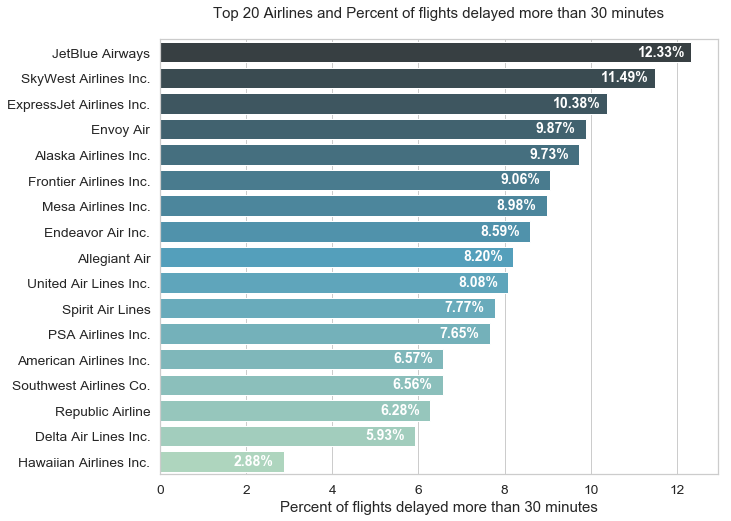

In [28]:
plt.figure(figsize=(10,8))
ax = sns.barplot(x='percent_delayed', y='airline', data=delays, palette='GnBu_d')

# Get delays greater than 30 minutes
temp_df['arr_delay'] = temp_df['arr_delay'].apply(lambda x: 30 if x >=30 else x)
temp_df['arr_delay'] = temp_df['arr_delay'].apply(lambda x: -30 if x <= -30 else x)
ax.set_title('Top 20 Airlines and Percent of flights delayed more than 30 minutes\n')
ax.set_ylabel('')
ax.set_xlabel('Percent of flights delayed more than 30 minutes')
fig = ax.get_figure()

for p in ax.patches:
    width = p.get_width()
    ax.text(width-0.7,
           p.get_y()+p.get_height()/2. + 0.13,
           '{:1.2f}%'.format(width), ha='center', color='white', size='14', weight='bold')

### Airport Data Visualizations

Now that I have explored the airlines with the most flights, I will now go into exploring the airports with the most traffic determines by the amount of departures and arrivals. 

First, I will determine the top 50 airports by combining the arrival and destination airports into one column. Then, I will perform a count using `value_counts` to select the top 50 airports. 

In [29]:
airport = pd.DataFrame(pd.concat([df['origin'],df['dest']]),columns={'airports'})

In [30]:
top20 = pd.DataFrame(airport['airports'].value_counts().head(20)).reset_index()
top20.rename(index=str, columns={'index':'airports', 'airports':'count'},inplace=True)

top20.head()

,airports,count
0,ATL,55843
1,ORD,45320
2,DFW,41217
3,CLT,34260
4,DEN,32951


Next, I will import the latitude and longitude of all of the airports in our data and merge the information so that I can plot them on a map.

In [31]:
latlong = pd.read_csv('airport_latlong.csv', names=['airports', 'latitude', 'longitude'])
latlong.dropna(inplace=True)
latlong.head()

,airports,latitude,longitude
1,ABE,40.6514,-75.4342
2,ABI,32.4164,-99.6803
3,ABL,67.1058,-157.8540
4,ABQ,35.0494,-106.6250
5,ABR,45.4536,-98.4189


In [32]:
top20 = pd.merge(top20, latlong,how='left',on='airports')
top20.head()

,airports,count,latitude,longitude
0,ATL,55843,33.6558,-84.4333
1,ORD,45320,41.9796,-87.8825
2,DFW,41217,32.9222,-97.0409
3,CLT,34260,35.2226,-80.9460
4,DEN,32951,39.8396,-104.6720


In [33]:
top20 = pd.DataFrame(airport['airports'].value_counts().head(20)).reset_index()
top20.rename(index=str, columns={'index':'airports', 'airports':'count'},inplace=True)
top20.head()

top20 = pd.merge(top20, latlong, how='left', on='airports')

# top20.to_csv('top20_airports_jan_feb.csv', index=False)

Using the latitude and longitude information that I have merged into our new dataframe, I will plot the airports on a bubble map using plotly. To do this, first, I will have to create a text column with information regarding the airports and their counts.

In [34]:
import plotly.plotly as py
import plotly
plotly.tools.set_credentials_file(username='amyksu', api_key='wQLY4WWAgKw2NNG6VuAB')

In [35]:
top20['text'] = top20['airports'] + '<br> Total Flights:' + (top20['count']/1e3).astype(str) + ' (Thousands)'

Using plotly, I will create a plot. First, I will create 3 bins, the top 10, the 11th to 30th, and 31st to 50th airports. I will assign different colors to these groups, then name them.

In [36]:
#Create plot using Plotly
limits = [(0,10),(11,15),(16,20)]
colors = ['rgb(255, 192, 203)','rgb(162, 195, 189)','rgb(197, 138, 149)' ]
names = ["Top 10 Busiest","11-15","16-20"]
cities = []
scale = 120

for i in range(len(limits)):
    lim = limits[i]
    df_sub = top20[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['count']/scale,
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i] )
    cities.append(city)
    
layout = dict(
        title = 'Top 20 Busiest Airports by Traffic',
        showlegend = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict( data=cities, layout=layout )
py.iplot( fig, validate=False, filename='d3-map-top20-airports')

/Users/amyksu/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Next, I will plot the flight path for gliths with an average delay of more than 10 minutes. I will also use plotly to do this. 

First, I will make a subset from the data that contains only flights from the top 50 airports that were identified above.

In [37]:
top20_airports = top20['airports'].tolist()
sub = df[df['origin'].isin(top20_airports)]
sub = sub[sub['dest'].isin(top20_airports)]

Next, I will create a dataframe of the airports to plot the next plot.

In [38]:
airport_df = pd.DataFrame(sub['origin'].unique())
airport_df.rename(index=str, columns={0:'airports'}, inplace=True)

airport_df = pd.merge(airport_df, latlong,how='left',on='airports')
airport_df.head()

airport_key = pd.read_csv('L_AIRPORT.csv')
airport_key.rename(index=str, columns={'Code':'airports'}, inplace=True)
airport_df = pd.merge(airport_df, airport_key, how='left', on='airports')

In [39]:
airport_df.head()

,airports,latitude,longitude,Description
0,JFK,40.6437,-73.7900,"New York, NY: John F. Kennedy International"
1,LAX,33.9456,-118.3910,"Los Angeles, CA: Los Angeles International"
2,MSP,44.8793,-93.1987,"Minneapolis, MN: Minneapolis-St Paul Internati..."
3,ORD,41.9796,-87.8825,"Chicago, IL: Chicago O'Hare International"
4,SFO,37.6148,-122.3920,"San Francisco, CA: San Francisco International"


Now, I will create a dataframe with the flight paths, keeping only flights with an average delay of more than 30 minutes. This dataframe will also include the start and end latitude and longitude for each flight.

In [40]:
flight_df = sub[['origin', 'dest', 'arr_delay']].groupby(by=['origin','dest']).mean()
flight_df.reset_index(inplace=True)
flight_df['arr_delay'] = flight_df['arr_delay'].apply(lambda x: 0 if x<0 else round(x))
flight_df.dropna(inplace=True)
flight_df = flight_df[flight_df['arr_delay']>=30]

In [41]:
# add departure latitude/longitude
flight_df = pd.merge(flight_df, airport_df[['airports', 'latitude', 'longitude']], how='left', left_on='origin', right_on='airports')
flight_df.rename(index=str, columns={'latitude':'start_lat', 'longitude':'start_lon'}, inplace=True)

# add arrival latitude/longitude
flight_df = pd.merge(flight_df, airport_df[['airports', 'latitude', 'longitude']], how='left', left_on='dest', right_on='airports')
flight_df.rename(index=str, columns={'latitude':'end_lat', 'longitude':'end_lon'}, inplace=True)

flight_df.drop(['airports_x', 'airports_y'], axis=1, inplace=True)
flight_df.head()

,origin,dest,arr_delay,start_lat,start_lon,end_lat,end_lon
0,BOS,LAS,35,42.3717,-71.0281,36.0806,-115.1430
1,BOS,MSP,34,42.3717,-71.0281,44.8793,-93.1987
2,DEN,SFO,31,39.8396,-104.6720,37.6148,-122.3920
3,MSP,DFW,31,44.8793,-93.1987,32.9222,-97.0409
4,MSP,ORD,35,44.8793,-93.1987,41.9796,-87.8825


In [28]:
flight_df.to_csv('flight.csv',index=False)

Because of the way the plot is formatted, flights to Honolulu will not be accurately represented. As such, I will remove them from the dataframe.

In [43]:
flight_df = flight_df[flight_df['origin']!= 'HNL'].copy()
flight_df = flight_df[flight_df['dest']!= 'HNL'].copy()
airport_df = airport_df[airport_df['airports'] != 'HNL'].copy()

In [45]:
airports = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = airport_df['longitude'],
        lat = airport_df['latitude'],
        hoverinfo = 'text',
        text = airport_df['Description'],
        mode = 'markers',
        marker = dict( 
            size=2, 
            color='rgb(0, 0, 0)',
            line = dict(
                width=3,
                color='rgba(68, 68, 68, 0)'
            )
        ))]
        
flight_paths = []
for i in range(len(flight_df)):
    flight_paths.append(
        dict(
            type = 'scattergeo',
            locationmode = 'USA-states',
            lon = [flight_df['start_lon'][i], flight_df['end_lon'][i]],
            lat = [flight_df['start_lat'][i], flight_df['end_lat'][i]],
            mode = 'lines',
            line = dict(
                #width = 5,
                width = (float((flight_df['arr_delay'][i]-1)-flight_df['arr_delay'].min())/(float(flight_df['arr_delay'].max()-flight_df['arr_delay'].min())/2.0))+2,
                color = 'rgb(255, 51, 119)'
            ),
            #opacity = 1
            opacity = float(flight_df['arr_delay'][i])/float(flight_df['arr_delay'].max()),
        )
    )
    
layout = dict(
        title = 'Routes with an average delay of more than 30 minutes (January and February 2019)',
        showlegend = False, 
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            #scope='north america',
            #projection=dict( type='azimuthal equal area' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            countrycolor = 'rgb(255, 255, 255)',
        ),
    )
    
fig = dict( data=flight_paths + airports, layout=layout )
py.iplot( fig, filename='d3-top20-greater30-flight-paths' )

/Users/amyksu/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead

